# Fraunhofer pattern for two channel CPR (using phase different $\phi/2$)

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin

In [5]:
h=6.626e-34
hbar=h/2/np.pi
Qe=1.608e-19
Phi0=h/2/Qe

In [6]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [13]:
%%cython --pgo

#Use GNU compiler gcc-10 specified in .bash_profile
cimport numpy as np
from libc.math cimport sin, pi
import numpy as np


cdef double Qe=1.608e-19
cdef double hbar=6.626e-34/2/pi


### cdef is faster but can only be used for cython in this cell
#cpdef can be used for python outside this cell

cpdef double CPR(double G, double A, double eta, double C,double A0):
    '''
        Current-phase relationship for the junction
    '''
    return (sin(G)+eta*sin(2*G)+A*sin(G+C*pi)+A*eta*sin(2*G+2*C*pi))/A0

In [30]:
#def CPR(G,A,eta,A0,C):
#    return (np.sin(G)+A*np.sin(2*G+C))/A0
def normalizing_A(A,eta,C):
    Gmax=fmin(lambda x: -CPR(x,A,eta,C,1),0,disp=0)
    if CPR(Gmax,A,eta,C,1)==0:
        return 1
    else:
        return CPR(Gmax,A,eta,C,1)

In [36]:
def Asymmetric_Fraun(Jc, B, x_array,A,eta,C):
    A0=1#normalizing_A(A,eta,C)
    def Ic_phase(phase0):
        IC=0
        for i in range(0,len(x_array)):
            IC += Jc[i]*CPR(2*np.pi*L*B*x_array[i]/Phi0+phase0,A,eta,C,A0)
        return IC
    return Ic_phase(np.pi/2) #return Ic at a field B with a phase shift pi/2

In [37]:
def Standard_Fraun(Jc, B, x_array):
    IC = 0
    for i in range(0,len(Jc)):
        IC += Jc[i]*np.sin(2*np.pi*L*B*x_array[i]/Phi0+np.pi/2)
    return IC

In [52]:
L=(100+16*2)*1e-9
W=2e-7
#A=0.2
#eta=0.8
C=-0.7 # in the unit of pi

A_array=np.linspace(0,1,11)
eta_array=np.linspace(0,1,11)
print(A_array)
print(eta_array)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


### Experiment data: $I_C(B=0)=1.15\mu A$ and $I_C(B=16mT)=1.9$. Ratio$=0.6$ at $B=0$.

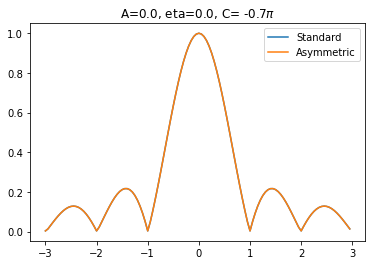

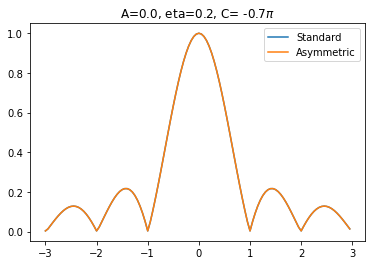

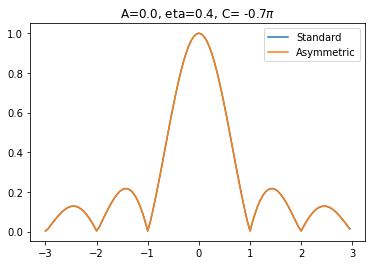

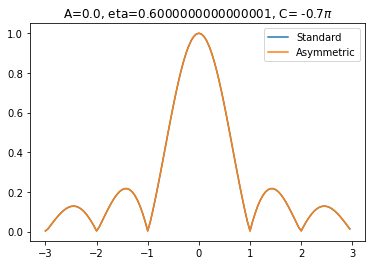

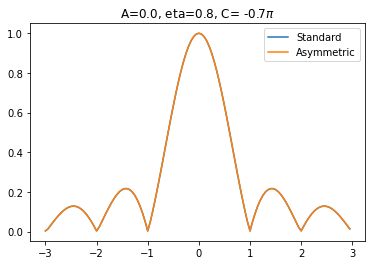

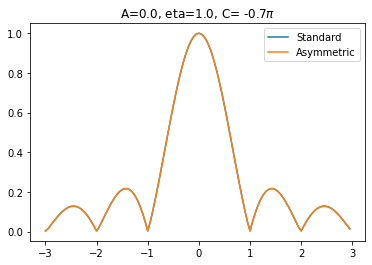

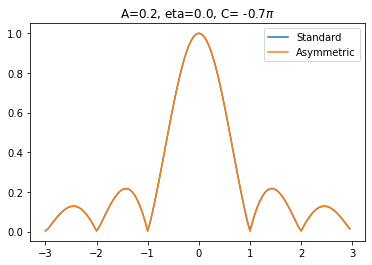

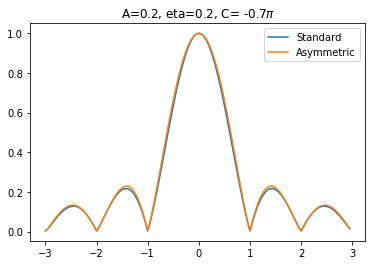

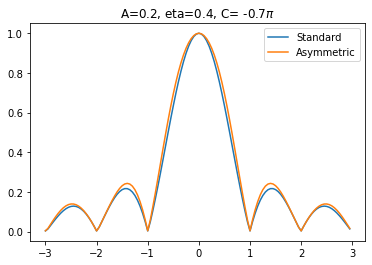

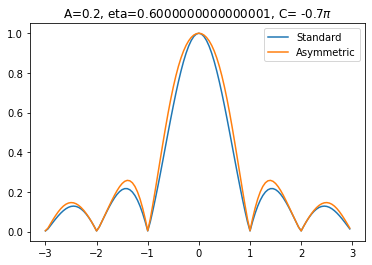

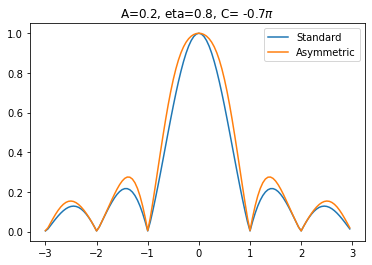

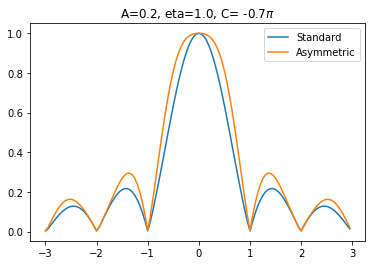

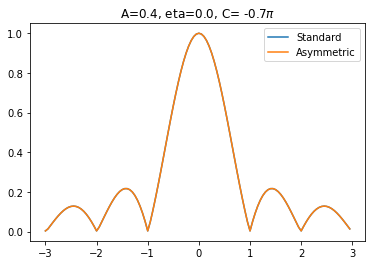

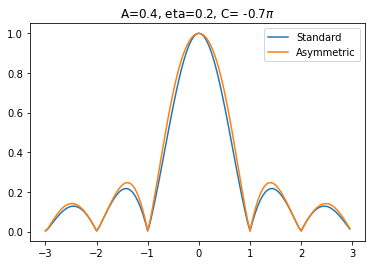

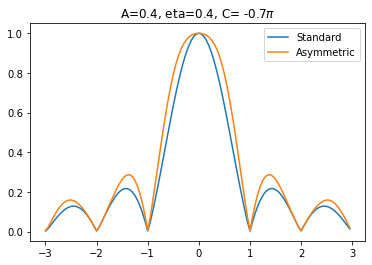

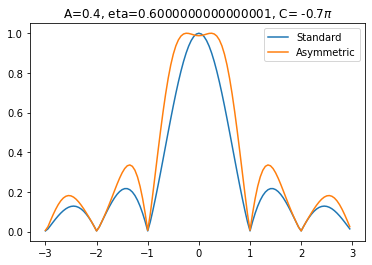

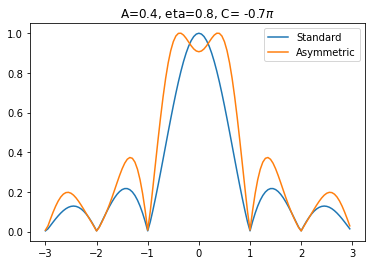

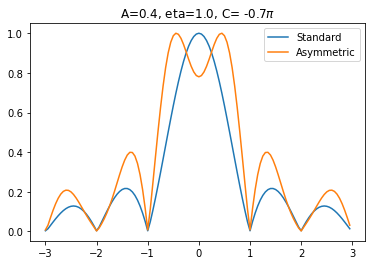

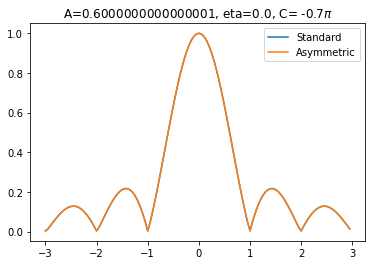

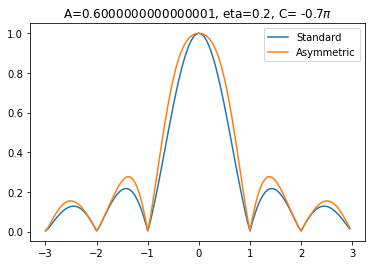

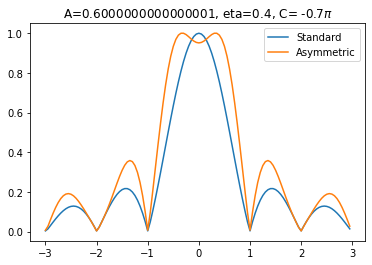

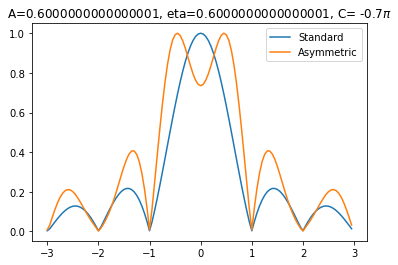

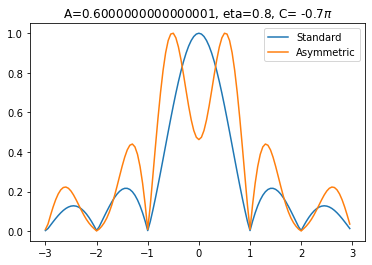

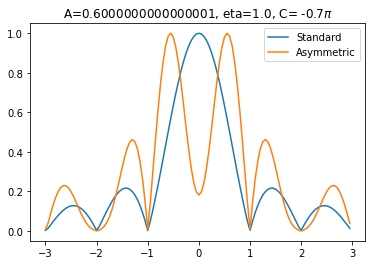

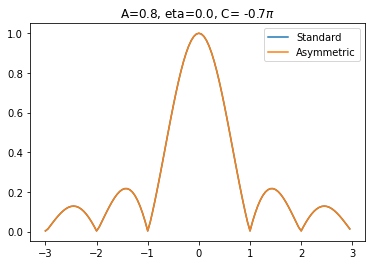

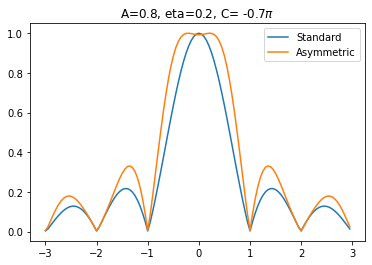

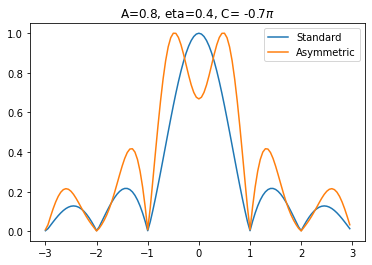

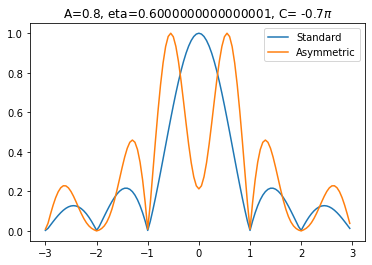

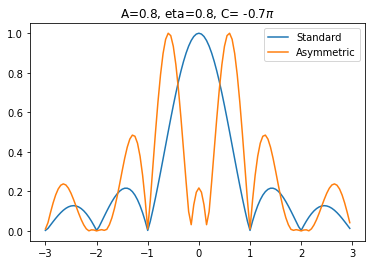

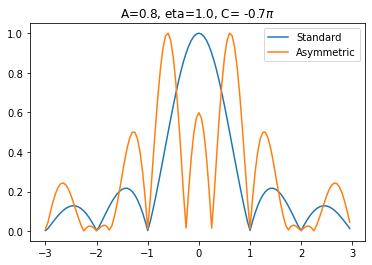

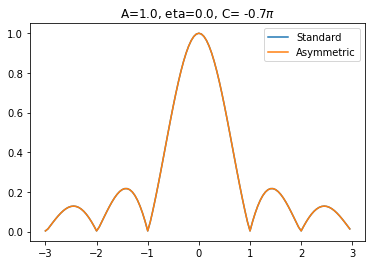

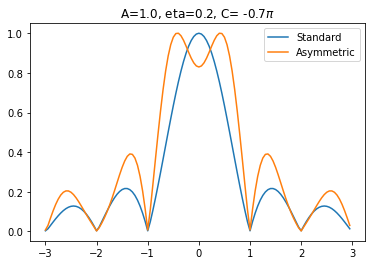

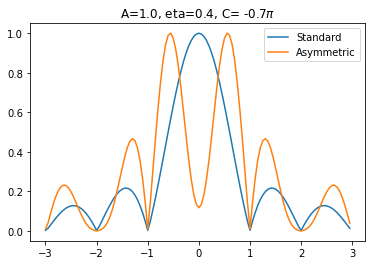

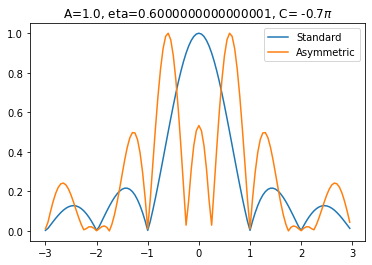

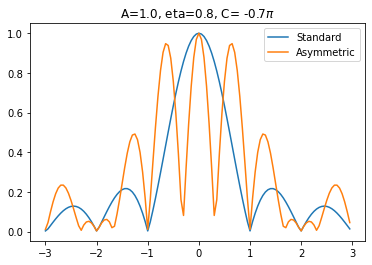

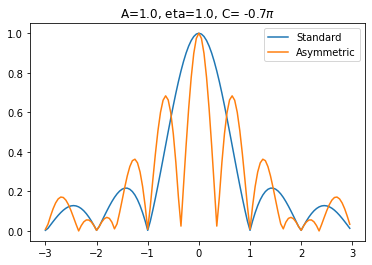

In [51]:
width = np.linspace(-W/2, W/2, 300)
uniform_Jc=np.ones(len(width))
B_fields = np.arange(-3,3,0.05) #normalized

Ic_Asymmetric = np.empty(len(B_fields))
Ic_Standard = np.empty(len(B_fields))

ratio=np.empty([len(A_array),len(eta_array)])
for i in range(0,len(A_array)):
    for j in range(0,len(eta_array)):
        for k in range(0,len(B_fields)):
            Ic_Asymmetric[k]=abs(Asymmetric_Fraun(uniform_Jc, B_fields[k]*(Phi0/L/W), width,A_array[i],eta_array[j],C))
            Ic_Standard[k]=abs(Standard_Fraun(uniform_Jc, B_fields[k]*(Phi0/L/W), width))
        ratio[i,j]=Ic_Asymmetric[len(B_fields)//2]/max(Ic_Asymmetric)
        print(str(ratio[i,j])+"at (A,eta)= ("+str(A_array[i])+", "+str(eta_array[j])+" )")
        plt.figure()
        plt.plot(B_fields, Ic_Standard/max(Ic_Standard)
                 , label = "Standard")
#plt.plot(B_fields,np.abs(np.sin(B_fields)/B_fields))
        plt.plot(B_fields, Ic_Asymmetric/max(Ic_Asymmetric)
                 , label = "Asymmetric")
        plt.title('A='+str(A_array[i])+', eta='+str(eta_array[j])+', C= '+str(C)+'$\pi$')
        plt.legend()
    #plt.savefig('A='+str(A)+'_C='+str(C)+'pi.pdf',format='pdf')
        plt.show()
